In [1]:
import cv2
from PIL import Image
import random
import os, glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def divide_image(image):
    sub_blocks = []
    sub_block_height = 40
    sub_block_width = 40
    
    s_p = [0, 44, 88]
    
    for s_i in s_p:
        for s_j in s_p:
            start_x = s_j
            start_y = s_i
            end_x = start_x + sub_block_width
            end_y = start_y + sub_block_height
            sub_block = image[start_y:end_y, start_x:end_x, :]
            sub_blocks.append(sub_block)
    return sub_blocks

In [3]:
data = []
labels = []
div_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/train/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/train/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_data.append(divide_image(image=img_arr))
        data.append(img_arr)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

['dog', 'bird', 'flower']


In [4]:
## test
test_data = []
test_labels = []
div_test_data = []

height = 128
width = 128
channels = 3
num_classes = 3

path = f'Linnaeus 5 128X128/test/'
Class = os.listdir(path)
print(Class)
for i, a in enumerate(Class):
    data_path = f'Linnaeus 5 128X128/test/{a}/'
    data_list = os.listdir(data_path)
    for d in data_list:
        image = cv2.imread(data_path + d)
        image_from_array = Image.fromarray(image, 'RGB')
        img_arr = np.array(image_from_array)
        div_test_data.append(divide_image(image=img_arr))
        test_data.append(img_arr)
        test_labels.append(i)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

['dog', 'bird', 'flower']


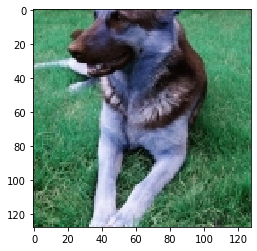

In [5]:
plt.imshow(test_data[0])

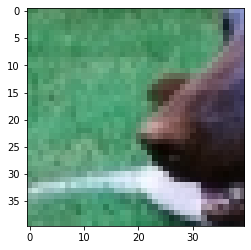

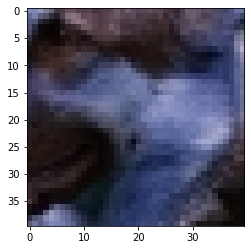

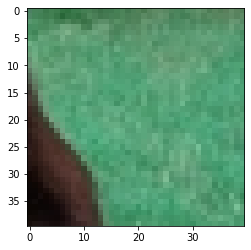

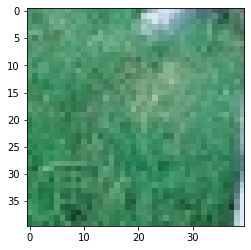

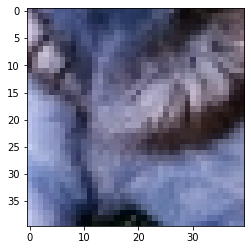

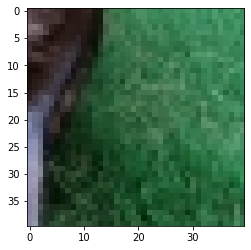

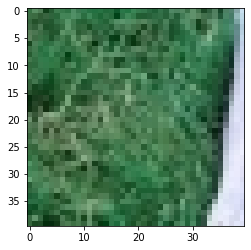

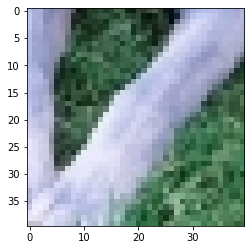

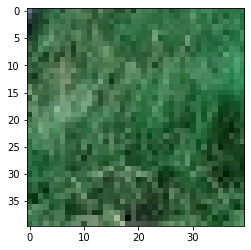

In [6]:
for im in np.array(div_test_data[0]):
    plt.figure()
    plt.imshow(im)


In [7]:
def reconstruct_image(combined_blocks):
    rows = []
    for i in range(0, 18, 3):
        row = np.concatenate(combined_blocks[i:i+3], axis=0)
        rows.append(row)
    merged_image = np.concatenate(rows, axis=1)
    return merged_image

def shuffle_blocks(blocks_a, blocks_b):
    shf_blocks = []
    for b_a, b_b in zip(blocks_a, blocks_b):
        random.shuffle(b_a)
        random.shuffle(b_b)
    
        mixed_sub_block = b_a + b_b
        random.shuffle(mixed_sub_block)
        shf_blocks.append(reconstruct_image(mixed_sub_block))
    return shf_blocks

In [8]:
def mk_shuffle_data(divided_data, d_size):
    
    label_idx = [0, d_size*1, d_size*2] 
    shf_labels = []
    shf_datas = []
    for i, l_i in enumerate(label_idx):
        class1 = divided_data[l_i : l_i+d_size]

        for j, l_i2 in enumerate(label_idx[i+1:]):
            if l_i == l_i2:
                continue
            class2 = divided_data[l_i2: l_i2+d_size]

            labels_list = [[l_i//d_size, l_i2//d_size]]* d_size
            shf_labels.append(labels_list)
            shf_datas.append(shuffle_blocks(class1, class2))
    return shf_datas, shf_labels

In [9]:
target_shf_datas, target_shf_labels = mk_shuffle_data(divided_data=div_test_data, d_size=test_data.shape[0]//3)

In [10]:
np.array(target_shf_datas).shape

(3, 400, 120, 240, 3)

In [11]:
shf_target_arr = np.array(target_shf_datas).reshape(-1,120, 240,3)

shf_target_arr.shape

(1200, 120, 240, 3)

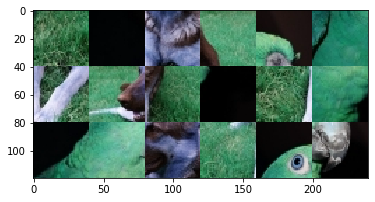

In [12]:
plt.imshow(shf_target_arr[0])

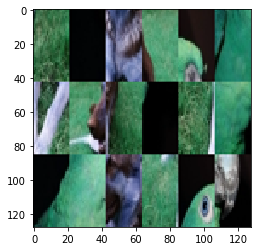

In [13]:

image_from_array = Image.fromarray(shf_target_arr[0], 'RGB')
resized_image = image_from_array.resize((128, 128))

plt.imshow(np.array(resized_image))

In [14]:
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input

In [15]:


def build_model():
    model = Sequential([
        Conv2D(64, (3,3), padding='same', activation="relu", input_shape=(height, width, 3)),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((2, 2)),
        
        Conv2D(256, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(128, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D((2, 2)),
        
        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        
        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D((2, 2)),
        
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax")])
    
    return model


def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

def ResNet50(input_shape = (height, width, 3), classes = 3):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = convolutional_block(X, 64, (3,3)) #conv
    X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(classes, activation = 'softmax')(X)

    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet50CL")
    
    return model


In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

In [17]:
x = data.astype('float32')
y = labels

# class_weights = dict(zip(np.unique(labels),
#                          compute_class_weight(class_weight = "balanced", classes=np.unique(labels), y = labels)))

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.2, shuffle=True, random_state=0)

x_train = x_train / 255.
x_val = x_val / 255.

# y_val = to_categorical(np.array(y_val))
# y_train = to_categorical(np.array(y_train))

model1 = ResNet50()

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)

rlr_call = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=4, verbose=1)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model1.compile(optimizer=opt, loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

with tf.device("/device:GPU:0"):
    history = model1.fit(x_train, y_train, epochs=200, batch_size=64, 
                        validation_data=(x_val, y_val),
                        callbacks=[rlr_call,EarlyStopping(monitor="val_loss", patience=10)])
    
#     history = model1.fit(x_train, y_train, epochs=200, batch_size=64, 
#                         validation_data=(x_val, y_val),
#                         callbacks=[rlr_call,EarlyStopping(monitor="val_loss", patience=10)],
#                         class_weight=class_weights)
    
    model1.save('resnet.h5')

Train on 2880 samples, validate on 720 samples
Epoch 1/200
2880/2880 [==============================] - 265s 92ms/sample - loss: 1.1034 - acc: 0.3358 - val_loss: 1.0988 - val_acc: 0.3139
Epoch 2/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0990 - val_acc: 0.3139
Epoch 3/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0991 - val_acc: 0.3139
Epoch 4/200
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0991 - val_acc: 0.3139
Epoch 5/200
2816/2880 [============================>.] - ETA: 0s - loss: 1.0986 - acc: 0.3388
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2880/2880 [==============================] - 42s 14ms/sample - loss: 1.0986 - acc: 0.3382 - val_loss: 1.0992 - val_acc: 0.3139
Epoch 6/200
2880/2880 [==============================] - 41s 14ms/sample - loss: 1.0985 - acc: